In [1]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models

In [2]:
torch.cuda.set_device(0)
device = torch.device('cuda')
loss_function = nn.CrossEntropyLoss()

In [3]:
images = torch.tensor(np.load("images.npy"), dtype=torch.float32)
labels = torch.tensor(np.load("labels.npy"), dtype=torch.long) - 1

split = int(images.shape[0]*1)
train_images = images[:split]
train_labels = labels[:split]

val_images = images[split:]
val_labels = labels[split:]

print(train_labels.shape)
print(val_labels.shape)

torch.Size([1348])
torch.Size([0])


In [4]:
class Model(nn.Module):
	def __init__(self):
		super().__init__()
		self.embedding = models.resnet18(weights='IMAGENET1K_V1')
		self.linear = nn.Linear(1000, 4)
	def forward(self, x):
		return self.linear(self.embedding(x))

In [5]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.to(device)

Model(
  (embedding): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [6]:
losses = []

In [7]:
n_epochs = 10
batch_size = 8

for epoch in range(n_epochs):
	permutation = torch.randperm(train_images.shape[0])
	for i in range(0, permutation.shape[0], batch_size):
		optimizer.zero_grad()

		indices = permutation[i:i+batch_size]
		x, y = train_images[indices], train_labels[indices]

		x = x.to(device)
		y = y.to(device)

		logits = model(x.permute(0, 3, 1, 2))
		loss = loss_function(logits, y)
		losses.append(loss.item())
		
		loss.backward()
		optimizer.step()

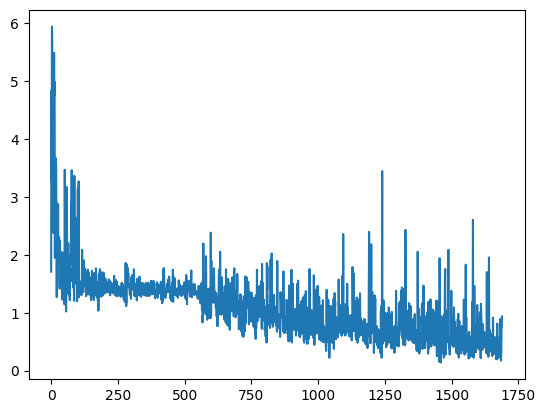

In [8]:
plt.plot(losses)

In [10]:
model.eval()
val_losses = []
for i in range(val_images.shape[0]):
	x = val_images[i:i+1]
	y = val_labels[i:i+1]
	
	x = x.to(device)
	y = y.to(device)

	logits = model(x.permute(0, 3, 1, 2))
	loss = loss_function(logits, y)
	val_losses.append(loss.item())
print(sum(val_losses)/len(val_losses))
model.train()

0.3272778134103175


Model(
  (embedding): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [9]:
import csv
files = os.listdir("test")
model.eval()
test_set = torch.tensor(np.load("test_set.npy"), dtype=torch.float32)
predictions = []
for i in range(test_set.shape[0]):
	t = test_set[i:i+1].to(device)
	l = model(t.permute(0, 3, 1, 2))
	predictions.append(torch.argmax(torch.softmax(l, dim=1)).item()+1)
print(len(predictions))
print(len(files))
dictionary = []
for i in range(len(files)):
	dictionary.append([files[i], predictions[i]])
with open("answers.csv", mode='w', newline='') as file:
	writer = csv.writer(file)
	writer.writerows(dictionary)
model.train()

85
85


Model(
  (embedding): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run